In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio

import healpy as hp
from astropy import units as u
from astropy.coordinates import SkyCoord

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
gaia_dir = '/project/projectdirs/cosmo/data/gaia/dr2/healpix'

gaia_nside = 32
print('Healpix resolution (arcmin):', np.sqrt(hp.nside2resol(gaia_nside, arcmin=True)))

Healpix resolution (arcmin): 10.4850162221


In [4]:
gaia_npix = hp.nside2npix(gaia_nside)
gaia_hp_ra, gaia_hp_dec = hp.pix2ang(gaia_nside, np.arange(gaia_npix), nest=True, lonlat=True)
c = SkyCoord(gaia_hp_ra, gaia_hp_dec, unit='deg')
tmp = c.galactic
gaia_hp_l, gaia_hp_b = tmp.l.to_value('deg'), tmp.b.to_value('deg')

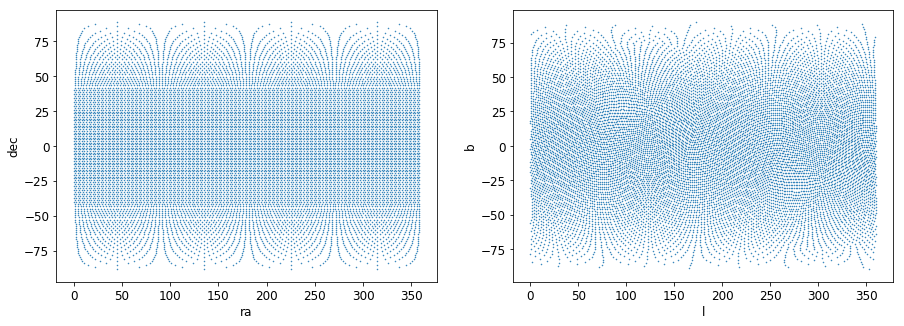

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(gaia_hp_ra, gaia_hp_dec, '.', ms=1)
ax[0].set_xlabel('ra')
ax[0].set_ylabel('dec')
ax[1].plot(gaia_hp_l, gaia_hp_b, '.', ms=1);
ax[1].set_xlabel('l')
ax[1].set_ylabel('b')
plt.show()

__Trim to DR9-SV footprint__

In [6]:
randoms_path = '/global/project/projectdirs/cosmo/data/legacysurvey/dr9sv/randoms/randoms-dr9-hp-X-1.fits'

randoms_columns = ['BRICKNAME', 'RA', 'DEC', 'MASKBITS', 'PHOTSYS']
randoms_full_size = fitsio.read_header(randoms_path, ext=1)['NAXIS2']
randoms_load_size = int(1e6)
randoms = fitsio.read(randoms_path, columns=randoms_columns, rows=np.arange(randoms_load_size))
randoms = Table(randoms)
print(len(randoms))
print(np.unique(randoms['PHOTSYS'], return_counts=True))

mask_south = randoms['PHOTSYS']=='S'
mask_north = ~mask_south

1000000
(<Column name='PHOTSYS' dtype='bytes1' length=2>
N
S, array([341257, 658743]))


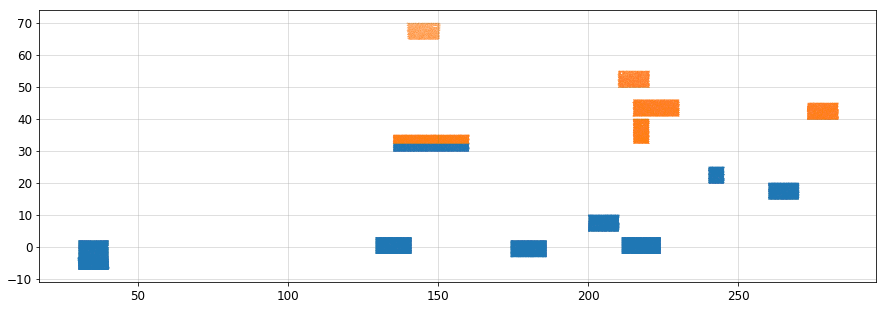

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(randoms['RA'][mask_south], randoms['DEC'][mask_south], '.', ms=0.1, alpha=0.1)
plt.plot(randoms['RA'][mask_north], randoms['DEC'][mask_north], '.', ms=0.1, alpha=0.1)
plt.grid(alpha=0.5)
plt.show()

In [8]:
randoms_hp_idx_south = hp.ang2pix(gaia_nside, randoms['RA'][mask_south], randoms['DEC'][mask_south], nest=True, lonlat=True)
randoms_hp_idx_north = hp.ang2pix(gaia_nside, randoms['RA'][mask_north], randoms['DEC'][mask_north], nest=True, lonlat=True)

randoms_hp_idx_south = np.unique(hp.get_all_neighbours(gaia_nside, randoms_hp_idx_south, nest=True))
randoms_hp_idx_north = np.unique(hp.get_all_neighbours(gaia_nside, randoms_hp_idx_north, nest=True))

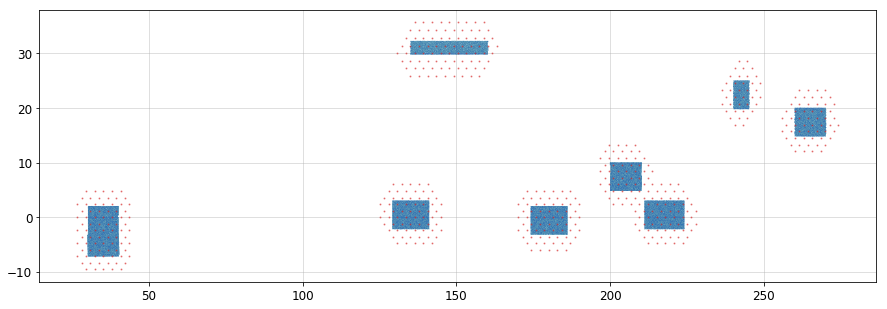

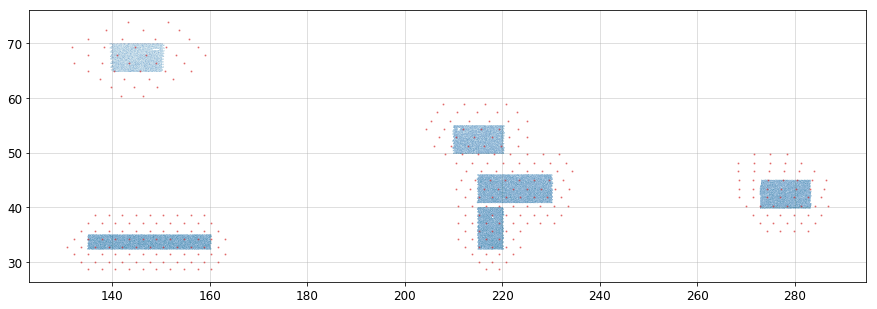

In [9]:
ra_tmp, dec_tmp = hp.pix2ang(gaia_nside, randoms_hp_idx_south, nest=True, lonlat=True)
plt.figure(figsize=(15, 5))
plt.plot(randoms['RA'][mask_south], randoms['DEC'][mask_south], '.', ms=0.1, alpha=0.1)
plt.plot(ra_tmp, dec_tmp, '.', ms=2, alpha=0.5, c='C3')
plt.grid(alpha=0.5)
plt.show()

ra_tmp, dec_tmp = hp.pix2ang(gaia_nside, randoms_hp_idx_north, nest=True, lonlat=True)
plt.figure(figsize=(15, 5))
plt.plot(randoms['RA'][mask_north], randoms['DEC'][mask_north], '.', ms=0.1, alpha=0.1)
plt.plot(ra_tmp, dec_tmp, '.', ms=2, alpha=0.5, c='C3')
plt.grid(alpha=0.5)
plt.show()

__Plot magnitude distribution__

12194


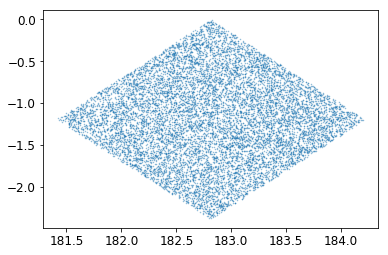

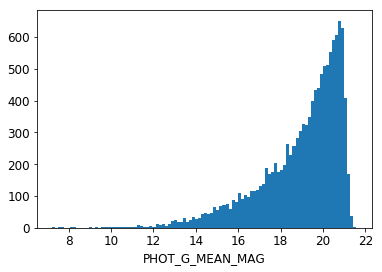

In [10]:
gaia = fitsio.read('/project/projectdirs/cosmo/data/gaia/dr2/healpix/healpix-06568.fits')
gaia = Table(gaia)
print(len(gaia))

plt.plot(gaia['RA'], gaia['DEC'], '.', ms=1, alpha=0.5)
plt.show()

plt.hist(gaia['PHOT_G_MEAN_MAG'], 100)
plt.xlabel('PHOT_G_MEAN_MAG')
plt.show()

__Combine the GAIA catalogs into a single catalog__

In [11]:
gaia = []
for hp_idx in randoms_hp_idx_south:
    gaia_fn = (5-len(str(hp_idx)))*'0'+str(hp_idx)
    tmp = fitsio.read(os.path.join(gaia_dir, 'healpix-{}.fits'.format(gaia_fn)), colnames=['PHOT_G_MEAN_MAG'])
    # select GAIA_G<20 objects
    idx = np.where(tmp['PHOT_G_MEAN_MAG']<20)[0]
    tmp = fitsio.read(os.path.join(gaia_dir, 'healpix-{}.fits'.format(gaia_fn)), rows=idx)
    tmp = Table(tmp)
    gaia.append(tmp)
gaia = vstack(gaia)
print(len(gaia))

gaia.write('/global/cscratch1/sd/rongpu/dr9dev/gaia_in_dr9sv/brightest_g_less_than_19_stars-dr9sv_south.fits')

7409227


In [12]:
gaia = []
for hp_idx in randoms_hp_idx_north:
    gaia_fn = (5-len(str(hp_idx)))*'0'+str(hp_idx)
    tmp = fitsio.read(os.path.join(gaia_dir, 'healpix-{}.fits'.format(gaia_fn)), colnames=['PHOT_G_MEAN_MAG'])
    # select GAIA_G<20 objects
    idx = np.where(tmp['PHOT_G_MEAN_MAG']<20)[0]
    tmp = fitsio.read(os.path.join(gaia_dir, 'healpix-{}.fits'.format(gaia_fn)), rows=idx)
    tmp = Table(tmp)
    gaia.append(tmp)
gaia = vstack(gaia)
print(len(gaia))

gaia.write('/global/cscratch1/sd/rongpu/dr9dev/gaia_in_dr9sv/brightest_g_less_than_19_stars-dr9sv_north.fits')

4259610


7409227


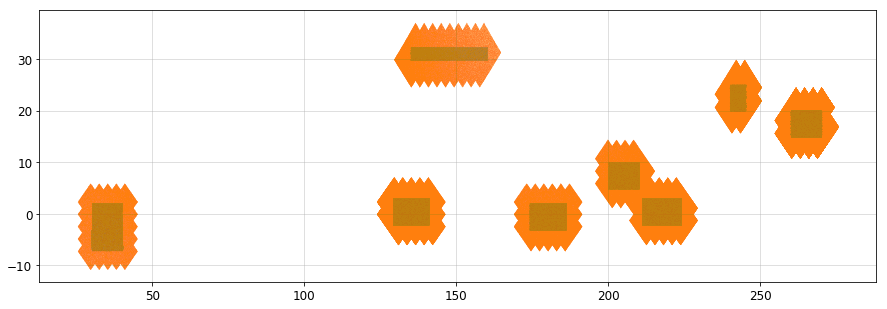

In [13]:
gaia = fitsio.read('/global/cscratch1/sd/rongpu/dr9dev/gaia_in_dr9sv/brightest_g_less_than_19_stars-dr9sv_south.fits', columns=['RA', 'DEC', 'PHOT_G_MEAN_MAG'])
print(len(gaia))
plt.figure(figsize=(15, 5))
plt.plot(randoms['RA'][mask_south], randoms['DEC'][mask_south], '.', ms=0.1, alpha=0.1)
plt.plot(gaia['RA'], gaia['DEC'], '.', ms=0.1, alpha=0.1)
plt.grid(alpha=0.5)
plt.show()

4259610


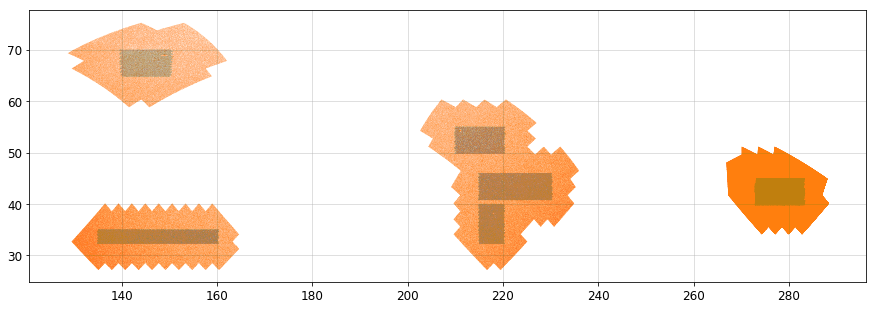

In [14]:
gaia = fitsio.read('/global/cscratch1/sd/rongpu/dr9dev/gaia_in_dr9sv/brightest_g_less_than_19_stars-dr9sv_north.fits', columns=['RA', 'DEC', 'PHOT_G_MEAN_MAG'])
print(len(gaia))
plt.figure(figsize=(15, 5))
plt.plot(randoms['RA'][mask_north], randoms['DEC'][mask_north], '.', ms=0.1, alpha=0.1)
plt.plot(gaia['RA'], gaia['DEC'], '.', ms=0.1, alpha=0.1)
plt.grid(alpha=0.5)
plt.show()

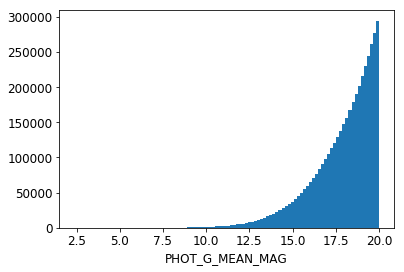

In [15]:
plt.hist(gaia['PHOT_G_MEAN_MAG'], 100)
plt.xlabel('PHOT_G_MEAN_MAG')
plt.show()